In [1]:
# -*- coding: utf-8 -*-
"""
Forward Euler solver for DDE with time-discrete Ising machine models. Can be modified for time-continuous models
Created on Tue Apr 20 11:07:31 2021

@author: Fabian
"""
import numpy as np

def map_clip(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip(a*old+b*np.dot(coup,old)+.40*b*bias+np.random.normal(0,noi,len(old)),-.4,.4)

def map_cos(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip(a*old+b*np.dot(coup,old)+.40*b*bias+np.random.normal(0,noi,len(old)),-.4,.4)

def map_pol(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip((a)*old-old**3+b*np.dot(coup,old)+np.abs(np.max(old))*b*bias+np.random.normal(0,noi,len(old)),-10,10)

def map_tanh(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.tanh(a*old+b*np.dot(coup,old)+np.abs(np.max(old))*b*bias+np.random.normal(0,noi,len(old)))


def ising_energy(stuff,ad,bias):
    return -0.5*1*np.dot(stuff,np.dot(ad,stuff))-np.sum(np.dot(bias,stuff))

def ising_sample(NN,n_hid):   
    global result
    global ens2
    global ad
    global chain
    global bias
    test=np.loadtxt(r'bla.txt') #edge list
    N=int(np.max(test)) #number of nodes
    #negat=np.abs(np.identity(N)-1)
    ad=np.zeros((N,N)) #adjacency matrix
    for i in range(0,len(test)): #initialize
        ad[int(test[i,0])-1,int(test[i,1])-1]+=(test[i,2])
    bias=np.zeros(N)
    for i in range(0,N):
        bias[i]+=ad[i,i]
        ad[i,i]=0
    # parameters for alpha and beta
    a=0.6
    b=0.75
    noise_strength=0.12

    chain=np.zeros(N)
    ens2=np.zeros(NN)
    result=np.zeros((NN,N))
    for i in range(0,NN):
        chain=map_clip(chain,ad,bias,a,b,noise_strength)   #calls Euler integration step, chose the map_xxx function to select different nonlinearities
        result[i,:]=chain
        ens2[i]=ising_energy(chain,ad,bias)
            
    return [0.5*(np.sign(result[:,:n_hid])+1),0.5*(np.sign(result[:,n_hid:])+1)]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap']='gray'
def gen_minst_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20,-1,8,8),0,2),1,3).reshape(-1,20*8)

In [3]:
"""Restricted Boltzmann Machine
"""

# Authors: Yann N. Dauphin <dauphiya@iro.umontreal.ca>
#          Vlad Niculae
#          Gabriel Synnaeve
#          Lars Buitinck
# License: BSD 3 clause

import time

import numpy as np
import scipy.sparse as sp
from scipy.special import expit  # logistic function

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import gen_even_slices
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.extmath import log_logistic
from sklearn.utils.validation import check_is_fitted, _deprecate_positional_args
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets, metrics
class BernoulliRBM(TransformerMixin, BaseEstimator):
    """Bernoulli Restricted Boltzmann Machine (RBM).

    A Restricted Boltzmann Machine with binary visible units and
    binary hidden units. Parameters are estimated using Stochastic Maximum
    Likelihood (SML), also known as Persistent Contrastive Divergence (PCD)
    [2].

    The time complexity of this implementation is ``O(d ** 2)`` assuming
    d ~ n_features ~ n_components.

    Read more in the :ref:`User Guide <rbm>`.

    Parameters
    ----------
    n_components : int, default=256
        Number of binary hidden units.

    learning_rate : float, default=0.1
        The learning rate for weight updates. It is *highly* recommended
        to tune this hyper-parameter. Reasonable values are in the
        10**[0., -3.] range.

    batch_size : int, default=10
        Number of examples per minibatch.

    n_iter : int, default=10
        Number of iterations/sweeps over the training dataset to perform
        during training.

    verbose : int, default=0
        The verbosity level. The default, zero, means silent mode.

    random_state : integer or RandomState, default=None
        Determines random number generation for:

        - Gibbs sampling from visible and hidden layers.

        - Initializing components, sampling from layers during fit.

        - Corrupting the data when scoring samples.

        Pass an int for reproducible results across multiple function calls.
        See :term:`Glossary <random_state>`.

    Attributes
    ----------
    intercept_hidden_ : array-like, shape (n_components,)
        Biases of the hidden units.

    intercept_visible_ : array-like, shape (n_features,)
        Biases of the visible units.

    components_ : array-like, shape (n_components, n_features)
        Weight matrix, where n_features in the number of
        visible units and n_components is the number of hidden units.

    h_samples_ : array-like, shape (batch_size, n_components)
        Hidden Activation sampled from the model distribution,
        where batch_size in the number of examples per minibatch and
        n_components is the number of hidden units.

    Examples
    --------

    >>> import numpy as np
    >>> from sklearn.neural_network import BernoulliRBM
    >>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
    >>> model = BernoulliRBM(n_components=2)
    >>> model.fit(X)
    BernoulliRBM(n_components=2)

    References
    ----------

    [1] Hinton, G. E., Osindero, S. and Teh, Y. A fast learning algorithm for
        deep belief nets. Neural Computation 18, pp 1527-1554.
        https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf

    [2] Tieleman, T. Training Restricted Boltzmann Machines using
        Approximations to the Likelihood Gradient. International Conference
        on Machine Learning (ICML) 2008
    """
    @_deprecate_positional_args
    def __init__(self, n_components=256, *, learning_rate=0.1, batch_size=100,
                 n_iter=30, verbose=0, random_state=None):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.verbose = verbose
        self.random_state = random_state

    def transform(self, X):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self)

        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        return self._mean_hiddens(X)

    def _mean_hiddens(self, v):
        """Computes the probabilities P(h=1|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        p = safe_sparse_dot(v, self.components_.T)
        p += self.intercept_hidden_
        return expit(p, out=p)

    def _sample_hiddens(self, v, rng):
        """Sample from the distribution P(h|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to sample from.

        rng : RandomState
            Random number generator to use.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.
        """
        p = self._mean_hiddens(v)
        return (rng.random_sample(size=p.shape) < p)

    def _sample_visibles(self, h, rng):
        """Sample from the distribution P(v|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState
            Random number generator to use.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.
        """
        p = np.dot(h, self.components_)
        p += self.intercept_visible_
        expit(p, out=p)
        return (rng.random_sample(size=p.shape) < p)

    def _free_energy(self, v):
        """Computes the free energy F(v) = - log sum_h exp(-E(v,h)).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        free_energy : ndarray of shape (n_samples,)
            The value of the free energy.
        """
        return (- safe_sparse_dot(v, self.intercept_visible_)
                - np.logaddexp(0, safe_sparse_dot(v, self.components_.T)
                               + self.intercept_hidden_).sum(axis=1))

    def gibbs(self, v):
        """Perform one Gibbs sampling step.

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to start from.

        Returns
        -------
        v_new : ndarray of shape (n_samples, n_features)
            Values of the visible layer after one Gibbs step.
        """
        check_is_fitted(self)
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        h_ = self._sample_hiddens(v, self.random_state_)
        v_ = self._sample_visibles(h_, self.random_state_)

        return v_

    def partial_fit(self, X, y=None):
        """Fit the model to the data X which should contain a partial
        segment of the data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        if not hasattr(self, 'random_state_'):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, 'components_'):
            self.components_ = np.asarray(
                self.random_state_.normal(
                    0,
                    0.01,
                    (self.n_components, X.shape[1])
                ),
                order='F')
        if not hasattr(self, 'intercept_hidden_'):
            self.intercept_hidden_ = np.zeros(self.n_components, )
        if not hasattr(self, 'intercept_visible_'):
            self.intercept_visible_ = np.zeros(X.shape[1], )
        if not hasattr(self, 'h_samples_'):
            self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X, self.random_state_)

    def _fit(self, v_pos, rng):
        """Inner fit for one mini-batch.

        Adjust the parameters to maximize the likelihood of v using
        Stochastic Maximum Likelihood (SML).

        Parameters
        ----------
        v_pos : ndarray of shape (n_samples, n_features)
            The data to use for training.

        rng : RandomState
            Random number generator to use for sampling.
        """
        h_pos = self._mean_hiddens(v_pos)
        self.make_jij()

        #uncomment line below for CIM Sampling
        h_neg,v_neg=ising_sample(1000,len(self.components_))
        #uncomment line below for Metropolis Sampling
        #h_neg,v_neg=mcmc_sample(10000,len(self.components_))
        #uncomment line below for Gibbs sampling
        #v_neg = self._sample_visibles(self.h_samples_, rng)
        #h_neg = self._mean_hiddens(v_neg)
        
        lengg=(len(h_neg))

        lr = float(self.learning_rate) / v_pos.shape[0]
        update = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T
        update -= np.dot(h_neg.T, v_neg)/(lengg/self.batch_size)
        self.components_ += lr * update
        self.intercept_hidden_ += lr * (h_pos.sum(axis=0) - h_neg.sum(axis=0)/(lengg/self.batch_size))
        self.intercept_visible_ += lr * (np.asarray(
                                         v_pos.sum(axis=0)).squeeze() -
                                         v_neg.sum(axis=0)/(lengg/self.batch_size))

        h_neg[rng.uniform(size=h_neg.shape) < h_neg] = 1.0  # sample binomial
        self.h_samples_ = np.floor(h_neg, h_neg)

    def score_samples(self, X):
        """Compute the pseudo-likelihood of X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).

        Returns
        -------
        pseudo_likelihood : ndarray of shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).

        Notes
        -----
        This method is not deterministic: it computes a quantity called the
        free energy on X, then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self)

        v = check_array(X, accept_sparse='csr')
        rng = check_random_state(self.random_state)

        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]),
               rng.randint(0, v.shape[1], v.shape[0]))
        if sp.issparse(v):
            data = -2 * v[ind] + 1
            v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]

        fe = self._free_energy(v)
        fe_ = self._free_energy(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    def make_jij(self):
        temp=np.zeros(0)
        #print(self.components_)
        n_hidd=len(self.components_)
        n_vis=len(self.components_[0])
        for i in range(0,n_hidd):
                        
            for j in range(0,n_vis):
                if(self.components_[i,j]!=0):
                    temp=np.append(temp,[(i+1),(j+1+n_hidd),0.25*(self.components_[i,j])])
                    temp=np.append(temp,[(j+1+n_hidd),(i+1),0.25*(self.components_[i,j])])
                   
        for i in range(0,n_hidd):
            temp2=0
            for j in range(0,n_vis):
                temp2+=self.components_[i,j]
            temp=np.append(temp,[i+1,i+1,(0.5*self.intercept_hidden_[i]+0.25*temp2)])
            
        for i in range(0,n_vis):
            temp2=0
            for j in range(0,n_hidd):
                temp2+=self.components_[j,i]
            temp=np.append(temp,[n_hidd+i+1,n_hidd+i+1,(0.5*self.intercept_visible_[i]+0.25*temp2)])
        
        temp=temp.reshape(2*n_hidd*n_vis+n_hidd+n_vis,3)
        np.savetxt(r'bla.txt',temp,delimiter=' ',newline='\n',fmt='%.10f')
        
    
    def fit(self, X, Y_train, X_test, Y_test):
        """Fit the model to the data X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
        logistic.C = 6000.0
        X = self._validate_data(X, accept_sparse='csr', dtype=np.float64)
        n_samples = X.shape[0]
        rng = check_random_state(self.random_state)
        
        self.batch_size=100
        likelhd=np.zeros(2161)
        predic=np.zeros(2161)
        self.components_ = np.asarray(
            rng.normal(0, 0.01, (self.n_components, X.shape[1])),
            order='F')
        self.intercept_hidden_ = np.zeros(self.n_components, )
        self.intercept_visible_ = np.zeros(X.shape[1], )
        self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        n_batches = int(np.ceil(float(n_samples) / self.batch_size)) #7188/100 71
        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, n_samples=n_samples))
        verbose = self.verbose
        begin = time.time()
        numnum=0 #n_batch * self.n_iter
        likelhd=[]
        predic=[]
        for iteration in range(1, self.n_iter + 1):
            for batch_slice in batch_slices:
                numnum+=1
                self._fit(X[batch_slice], rng)
                if verbose:
                    end = time.time()
                    # likelhd[numnum-1]=self.score_samples(X).mean()
                    likelhd.append(self.score_samples(X).mean())
                    # predic[numnum]=logistic.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test)
                    print("[%s] Iteration %d, pseudo-likelihood = %.2f," " time = %.2fs" % (type(self).__name__, numnum, self.score_samples(X).mean(), end - begin))
                    begin = end
                    # predic[numnum]=logistic.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test)
                    
                    predic.append(logistic.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test))
                    print(predic[numnum-1])
                    if (numnum-1)%20==0:
                        xx = X[:40].copy()
                        for ii in range(1000):
                            for n in range(40):
                                xx[n]=rbm.gibbs(xx[n])
                        plt.figure(figsize=(16,2))
                        plt.imshow(gen_minst_image(xx))
                        plt.show()
        #print(self.make_jij())
        plt.xlabel('Training iteration')  # X轴标签
        plt.ylabel('Pseudolikelihood ')  # Y轴标签
        plt.plot(likelhd)
        plt.show()
        plt.plot(predic)
        plt.xlabel('Training iteration')  # X轴标签
        plt.ylabel('Prediction accuracy')  # Y轴标签
        plt.show()
        np.savetxt('out_likelhd.txt',likelhd)
        np.savetxt('out_pred.txt',predic)
        return self

    def _more_tags(self):
        return {
            '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the decision_function method'
            }
        }

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo,list_available_datasets

# import dataset
pen_dataset = fetch_ucirepo(id=81)

# access data
X = pen_dataset.data.features
y = pen_dataset.data.targets
print(X.shape)
print(y.shape)

(10992, 16)
(10992, 1)


(7188, 64)


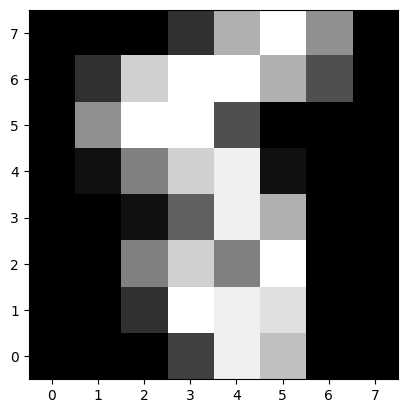

In [140]:
from sklearn.datasets import load_digits
import numpy as np
from scipy.ndimage import shift
from sklearn.model_selection import train_test_split
# 加载手写数字数据集
digits = load_digits()

# 获取图像数据和标签
images = digits.images  # 8x8 的图像矩阵
plt.imshow(images[2], origin='lower',cmap="gray")
labels = digits.target  # 对应的标签
##新的数据集
# 定义平移函数
def translate_image(image, direction):
    if direction == 'up':
        return shift(image, [-1, 0], mode='constant', cval=0)
    elif direction == 'down':
        return shift(image, [1, 0], mode='constant', cval=0)
    elif direction == 'left':
        return shift(image, [0, -1], mode='constant', cval=0)
    elif direction == 'right':
        return shift(image, [0, 1], mode='constant', cval=0)
    else:
        raise ValueError("Invalid direction. Use 'up', 'down', 'left', or 'right'.")
# 扩展数据集
expanded_images = []
expanded_labels = []
for image, label in zip(images, labels):
    # 原始图像
    expanded_images.append(image)
    expanded_labels.append(label)
    # 向四个方向平移
    for direction in ['up', 'down', 'left', 'right']:
        translated_image = translate_image(image, direction)
        expanded_images.append(translated_image)
        expanded_labels.append(label)
        # 将列表转换为 NumPy 数组
expanded_images= np.array(expanded_images)
expanded_labels= np.array(expanded_labels)
# 将图像数据展平为二维数组 (n_samples, 64)
n_samples = expanded_images.shape[0]
data = expanded_images.reshape((n_samples, -1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, expanded_labels, test_size=0.2, random_state=42)
X_train=(X_train-np.min(X_train,0))/(np.max(X_train,0)+0.0001)
X_test=(X_test-np.min(X_test,0))/(np.max(X_test,0)+0.0001)
print(X_train.shape)

In [109]:
# Définition de variables
X_noms = X.columns

# Conversion en np.ndarray
X = np.array(X)
y = np.array(y["Class"])

# Définition de variables
dim = len(X[0])
nb_labels = len(np.unique(y))



In [110]:
# Function to perform scan conversion
image_n=16

def scan_convert(handwriting_data, image_size=(image_n, image_n)):
    # Assuming handwriting_data is a numpy array with shape (num_points, 2)
    # Normalize handwriting data to fit within image_size
    min_val = np.min(handwriting_data, axis=0)
    max_val = np.max(handwriting_data, axis=0)
    normalized_data = (handwriting_data - min_val) * np.array(image_size) / (max_val - min_val)
    normalized_data = normalized_data.astype(int)
    # Create an empty bitmap
    bitmap = np.zeros(image_size, dtype=bool)
    
    # Draw strokes onto the bitmap
    for i in range(1, len(normalized_data)):
        x0, y0 = normalized_data[i-1]
        x1, y1 = normalized_data[i]
        draw_line(bitmap, x0, y0, x1, y1)
    
    return bitmap

# Function to draw a line onto a bitmap using Bresenham's algorithm
def draw_line(bitmap, x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    err = dx - dy
    while True:
        # Check if the current coordinates are within the bitmap boundaries
        if 0 <= x0 < bitmap.shape[1] and 0 <= y0 < bitmap.shape[0]:
            bitmap[y0, x0] = True

        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
from scipy.ndimage import gaussian_filter

# Function to blur and downsample the image
def blur_and_downsample(bitmap, blur_sigma=1, downsample_factor=2):
    # Apply Gaussian blur
    blurred_bitmap = gaussian_filter(bitmap.astype(float), sigma=blur_sigma)
    # Downsample the blurred bitmap
    downsampled_bitmap = blurred_bitmap [::downsample_factor, ::downsample_factor]
    return downsampled_bitmap

def render(number) : 
  src = X[np.where((y==number))]
  sample = X[:8]
  fig = plt.figure(figsize=(16, 2))
  nb = len(sample)
  for i in range(nb) : 
    shape = sample[i].reshape(8,2)
    fig.add_subplot(1, nb, i+1)
    convert = blur_and_downsample(scan_convert(shape))
    _ = plt.imshow(convert, origin='lower',cmap="gray")

(7188, 64)


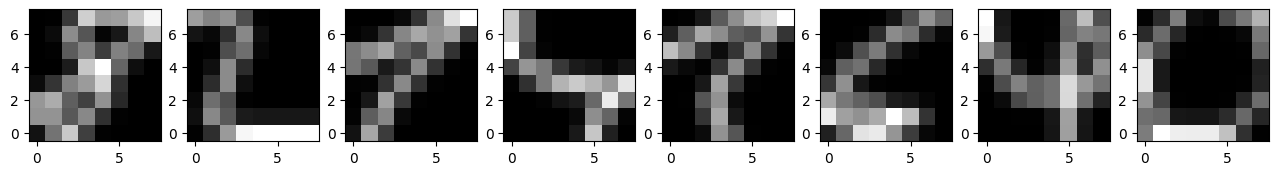

In [111]:
# Définition des 1
from sklearn.model_selection import train_test_split
one = X[np.where((y==1))]

render(8)
num=len(X)
x=np.zeros((num,8,2))
new_X=np.zeros((num,8,8))
for i in range(num):
    x[i]=X[i].reshape(8,2)
    new_X[i]=blur_and_downsample(scan_convert(x[i]))
X_train, X_test, y_train, y_test = train_test_split(new_X, y, train_size=7188, random_state=42)
X_train=X_train.reshape(X_train.shape[0],-1)
X_test=X_test.reshape(X_test.shape[0],-1)
X_train=(X_train-np.min(X_train,0))/(np.max(X_train,0)+0.0001)
X_test=(X_test-np.min(X_test,0))/(np.max(X_test,0)+0.0001)
print(X_train.shape)

In [112]:
import numpy as np
from collections import defaultdict
import random
# 假设 X_train 和 y_train 是你的训练数据和标签
# 这里我们用随机数据作为示例
np.random.seed(42)
# 按类别分组
class_indices = defaultdict(list)
for idx, label in enumerate(y_train):
    class_indices[label].append(idx)

# 设置随机种子以确保可重复性
random.seed(42)

# 初始化新的训练集和标签
new_X_train = []
new_y_train = []
# 计算需要多少个10样本组
num_groups = len(X_train) // 10
# 复制一份 class_indices，避免修改原始数据
class_indices_copy = {label: indices.copy() for label, indices in class_indices.items()}

for group in range(num_groups):
    # 从每个类别中随机选择一个样本
    for label in range(10):
        if not class_indices_copy[label]:
            continue
        # 随机选择一个样本索引
        sample_idx = random.choice(class_indices_copy[label])
        # 移除已选样本，避免重复选择
        class_indices_copy[label].remove(sample_idx)
        # 添加到新的训练集
        new_X_train.append(X_train[sample_idx])
        new_y_train.append(y_train[sample_idx])

# 转换为NumPy数组
new_X_train = np.array(new_X_train)
new_y_train = np.array(new_y_train)

# 验证结果
print("前10个样本的标签:", new_y_train[:10])
print("第11-20个样本的标签:", new_y_train[10:20])

# 输出新的训练集和标签
print("新的训练集形状:", new_X_train.shape)
print("新的标签形状:", new_y_train.shape)

前10个样本的标签: [0 1 2 3 4 5 6 7 8 9]
第11-20个样本的标签: [0 1 2 3 4 5 6 7 8 9]
新的训练集形状: (7011, 64)
新的标签形状: (7011,)



Test Set Performance:
Accuracy: 0.7935

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       188
           1       0.58      0.51      0.54       183
           2       0.81      0.80      0.80       172
           3       0.79      0.80      0.80       205
           4       0.88      0.86      0.87       168
           5       0.78      0.77      0.77       183
           6       0.91      0.93      0.92       183
           7       0.88      0.93      0.90       189
           8       0.68      0.66      0.67       160
           9       0.69      0.70      0.70       166

    accuracy                           0.79      1797
   macro avg       0.79      0.79      0.79      1797
weighted avg       0.79      0.79      0.79      1797



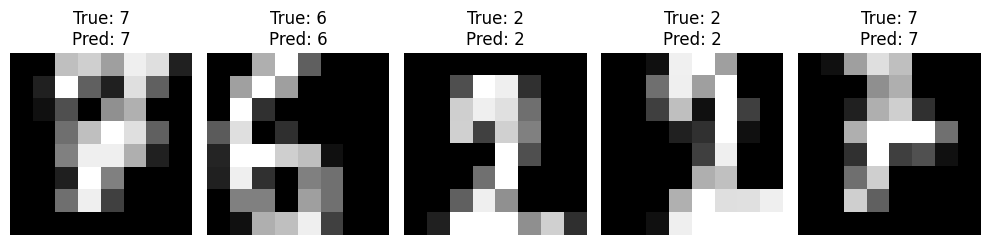

In [147]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# 训练逻辑回归模型
def train_logistic_regression(X_train, y_train):
    # 创建逻辑回归模型
    model = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=10000, random_state=42)    
    # 训练模型
    model.fit(X_train, y_train)
    
    return model

# 预测并评估模型性能
def evaluate_model(model, X_test, y_test):
    # 在测试集上进行预测
    y_pred = model.predict(X_test)
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# 可视化部分预测结果
def visualize_predictions(model, X_test, y_test, n_samples=5):
    # 获取预测结果
    y_pred = model.predict(X_test)
    
    # 随机选择 n_samples 个样本进行可视化
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(indices, start=1):
        plt.subplot(1, n_samples, i)
        img = X_test[idx].reshape(8, 8)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    # 训练逻辑回归模型
    model = train_logistic_regression(X_train, y_train)

    
    # 在测试集上评估模型
    print("\nTest Set Performance:")
    evaluate_model(model, X_test, y_test)
    
    
    # 可视化部分预测结果
    visualize_predictions(model, X_test, y_test)

In [ ]:
rbm = BernoulliRBM(n_components=100, learning_rate=0.1, random_state=0, verbose=True)
rbm.fit(X_train,y_train,X_test,y_test)

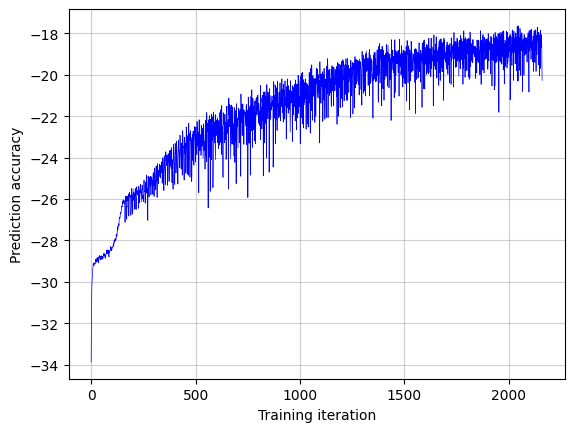

In [6]:
import matplotlib.pyplot as plt
import numpy as np
file_path = 'out_likelhd.txt'
y = np.loadtxt(file_path)
    # 设置 y 轴范围
# plt.ylim(0.7, 1)
plt.grid(True, linestyle='-', alpha=0.6)
    # 添加标题和标签
plt.xlabel('Training iteration')  # X轴标签
plt.ylabel('Prediction accuracy')  # Y轴标签
plt.savefig("flow_graph.png", format="PNG") 
plt.plot(y,color='blue', linestyle='-',linewidth=0.5)
plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# 我们要使用的模型：
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, batch_size=100,verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

rbm.learning_rate = 0.06
rbm.n_iter = 300

# 更多的组件倾向于提供更好的预测性能，但拟合时间更长
rbm.n_components = 100
logistic.C = 6000

# 培训RBM-Logistic管道
rbm_features_classifier.fit(X_train, y_train)

# 直接在像素上训练Logistic回归分类器
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)
# #############################################################################
# 评估

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()